## Read biosound H5 files and cluster
### After sorting some syllables/notes/calls in SoundSep you must first calculate spectral/temporal features of them with Biosound and store those features as H5 files. This is all done with save_biosound_h5files.ipynb.
### This notebook takes the H5 files, makes a Pandas DF, and does some clustering on them.

In [15]:
# from scipy import integrate, optimize

from scipy.signal import spectrogram, butter, sosfilt, sosfiltfilt, correlate
from scipy.io.wavfile import read, write
import IPython.display as ipd
# import sys
from collections import Counter
import os
import pandas as pd
# import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import pickle
import csv
from soundsig.sound import BioSound 
from soundsig.sound import WavFile

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA



# from ipywidgets import interact, fixed
# from ipywidgets import widgets
import matplotlib.pyplot as plt

def plot_a_spectrogram(w, fs:int=48000, title:str=spectrogram, nfft:int=2048):
    ff, tt, Sxx = spectrogram(w, fs=fs, nfft=nfft)
    max_ff = 10000 # only plot the first 10kHz
    ff_index = np.where(ff < max_ff)
    ff = ff[ff_index]
    Sxx = Sxx[ff_index]

    plt.figure(figsize=(10, 5))
    plt.pcolormesh(tt, ff[:max_ff], Sxx[:max_ff], cmap='plasma', shading='auto')
    # plt.pcolormesh(tt, ff[:145], Sxx[:145], cmap='plasma', shading='gouraud')
    plt.title(title)
    plt.xlabel('t (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.grid()


def print_missing_features(X, XFeatureNames, indBad):
    missing_features = list()
    for feature in XFeatureNames:
        num_missing=0
        for i in indBad: 
            if np.isnan(X[i,np.where(XFeatureNames == feature)[0][0]]):
                num_missing += 1
        if num_missing > 0: print(f'num missing {feature} = {num_missing}')

In [2]:
base_folder = "/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023"# _Maeves_data"
#"/Users/williamwood/Documents/Sound_Localization/for_soundsep/2023 maeve and jaewon/14_38_03_18_07_2023-data/"
h5_folder = 'h5filesAmp'

fs = 48000 # TODO find where to import fs instead of hardcoding it

os.chdir(os.path.join(base_folder, h5_folder))
print(os.getcwd())
files_list = os.listdir('.')
print(f'num files = {len(files_list)}, files_list[0] = {files_list[0]}')

/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/h5filesAmp
num files = 4345, files_list[0] = bird_WhiWhi6607F_call_["0"]_1134.h5


In [3]:
# Testing with one file
fname = files_list[0]

myBioSound = BioSound()
myBioSound.readh5(fname)
        
# Take the time average formants 
meanF1 = np.mean(myBioSound.F1[~np.isnan(myBioSound.F1)])
meanF2 = np.mean(myBioSound.F2[~np.isnan(myBioSound.F2)])
meanF3 = np.mean(myBioSound.F3[~np.isnan(myBioSound.F3)])
        
# These are our two identifier - the emitter (bird) and the call type
Bird = np.array2string(myBioSound.emitter)[2:-1]
callType = np.array2string(myBioSound.type)[2:-1]

print("The following values shouldn't be NaN or 0")
print(f'meanF1 = {meanF1}, meanF2 = {meanF2}, meanF3 = {meanF3}, Bird = {Bird}, callType = {callType}')

The following values shouldn't be NaN or 0
meanF1 = 1927.151856955459, meanF2 = 5606.097997000336, meanF3 = 8855.267794505857, Bird = WhiWhi6607F, callType = ["0"]


## If you have previously saved a pandas df from the H5 files you can skip the next two cells

In [4]:
# vocSelData is going to be a list of dictionary containing the values that we are going to extract from each BioSound object.
vocSelData = []

# Looping through all the files
i = 0
for fname in files_list:
    if fname.endswith('.h5'):
        # print(f'index = {i}, fname = {fname}')
        # print(fname)
        # Allocate object and read data
        myBioSound = BioSound()
        try:
            myBioSound.readh5(fname)
        except:
            print('Could not read h5 file', fname)
            continue
        
        # These are our two identifier - the emitter (bird) and the call type
        Bird = np.array2string(myBioSound.emitter)[2:-1]
        callType = np.array2string(myBioSound.type)[2:-1]

        # Get values for the fundamental
        if myBioSound.fund.size > 0:
            fund = float(myBioSound.fund)
            cvfund = float(myBioSound.cvfund)
            maxfund = float(myBioSound.maxfund)
            minfund = float(myBioSound.minfund)
            devfund = np.nanmean(np.diff(myBioSound.f0))
                    # Take the time average formants 
            meanF1 = np.mean(myBioSound.F1[~np.isnan(myBioSound.F1)])
            meanF2 = np.mean(myBioSound.F2[~np.isnan(myBioSound.F2)])
            meanF3 = np.mean(myBioSound.F3[~np.isnan(myBioSound.F3)])
        else:
            fund = -10 
            cvfund = 0   
            maxfund = 0
            # TODO add default value of devfund
            # TODO just notes here: play with UMAP neighborhood.
            # TODO play with HDBScan neighborhood. fit it. silhouette score. davis dun score. 
            # TODO # of unclassified calls.
            # TODO try to classifiy noise vs calls. force 2 clusters.
            # then look at soundsep. 
            minfund = 0
            devfund = 0
            meanF1 = 0
            meanF2 = 0
            meanF3 = 0
            

        vocSelData.append({"Bird": Bird, 
                     "project.start_index": int(fname.split('.')[0].split('_')[-1]),
                     "calltype": callType, 
                     "fund": fund, "devfund": devfund,
                     "cvfund": cvfund, "maxfund": maxfund, "minfund": minfund,
                     "F1": meanF1, "F2": meanF2, "F3":meanF3,
                     "sal": float(myBioSound.meansal), 
                     "rms": float(myBioSound.rms), 
                     "maxAmp": float(myBioSound.maxAmp),
                     "meanS": float(myBioSound.meanspect), "stdS": float(myBioSound.stdspect),
                     "skewS": float(myBioSound.skewspect), "kurtS": float(myBioSound.kurtosisspect), 
                     "entS": float(myBioSound.entropyspect),
                     "q1": float(myBioSound.q1), "q2": float(myBioSound.q2), "q3": float(myBioSound.q3),                  
                     "meanT": float(myBioSound.meantime), "stdT": float(myBioSound.stdtime),
                     "skewT": float(myBioSound.skewtime), "kurtT": float(myBioSound.kurtosistime),
                     "entT": float(myBioSound.entropytime)
        
})
        i += 1
        if ((i % 1000) == 0):
            print('Done with', i, 'files')
        #if (i == 10000):
            #break

print(f'Done with {i} files')


/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Done with 1000 files
Done with 2000 files


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_95619/1010463136.py:28: RuntimeWarning: Mean of empty slice
  devfund = np.nanmean(np.diff(myBioSound.f0))


Done with 3000 files
Done with 4000 files
Done with 4344 files


In [5]:
# Write the results to a pandas df

tableStore = os.path.join(base_folder,'vocSelTableAmp.h5')
vocSelTable = pd.DataFrame(vocSelData)
vocSelTable.to_hdf(tableStore, 'callTable', mode = 'w')

## If you already stored the H5 file just load it, skipping the above cells
## Either way, at this point we will also need to load the soundsep syllable csv from a couple steps up the pipeline

In [6]:
# You can also start the script here and skip the reading of h5 files and creation of table
# Read the vocSelTable
vocSelTableFull = pd.read_hdf(os.path.join(base_folder, 'vocSelTableAmp.h5')) # haven't trie dthis yet
print(len(vocSelTableFull))

4344


In [7]:
# Read the annotated_syllabes.csv file to get information on solo vs overlapp
syll_file_name = os.path.join(base_folder,'_appdata','save','segments.csv')
print(syll_file_name)

syllTable = pd.read_csv(syll_file_name, sep=',',header=0) 


vocSelTableFull = pd.merge(left=vocSelTable, right=syllTable, left_on='project.start_index', right_index=True) # it's possible that I'm losing a couple rows here
birds = np.unique(vocSelTable['Bird'])

/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/_appdata/save/segments.csv


In [8]:
# These values should look reasonable
vocSelTableFull

,Bird,project.start_index,calltype,fund,devfund,cvfund,maxfund,minfund,F1,F2,...,kurtT,entT,Unnamed: 0.1,Unnamed: 0,SourceName,SourceChannel,StartIndex,StopIndex,Tags,Coords
0,WhiWhi6607F,1134,"[""0""]",602.035277,0.020312,0.123225,676.056338,480.000000,1927.151857,5606.097997,...,2.037413,0.966456,1134,1134,WhiWhi6607F,1,57079776,57094045,"[""0""]","[11.74085807800293, 11.970152854919434, 3.5112..."
1,BluGre1214F,951,"[""6""]",532.179639,0.659361,0.171370,592.592593,298.136646,1223.147592,4405.922739,...,1.941768,0.994068,951,951,BluGre1214F,2,44063751,44067712,"[""6""]","[1.7445242404937744, 6.9982476234436035, 8.952..."
2,BluGre1214F,3202,"[""5""]",1004.070215,-1.918334,1.029701,3428.571429,539.325843,3282.440047,5674.842286,...,1.931446,0.993494,3202,3202,BluGre1214F,2,190241518,190243570,"[""5""]","[9.087912559509277, 12.039102554321289, 6.0388..."
3,WhiWhi6607F,2406,"[""6""]",606.338279,0.138851,0.031357,631.578947,564.705882,1153.195682,2492.185919,...,1.876354,0.998047,2406,2406,WhiWhi6607F,1,139155682,139160389,"[""6""]","[7.868463039398193, 13.822118759155273, 3.1498..."
4,BroGre1354M,311,"[""5""]",538.920136,0.645045,0.054985,564.705882,484.848485,2085.536237,3634.836575,...,1.929756,0.993356,311,311,BroGre1354M,0,19825492,19828354,"[""5""]","[9.96738338470459, 13.460389137268066, 5.66926..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4339,WhiWhi1541M,264,"[""5""]",2759.790084,88.223783,0.410419,3428.571429,640.000000,3032.627721,4153.134038,...,2.214188,0.981780,264,264,WhiWhi1541M,3,11007748,11009994,"[""5""]","[8.944231986999512, 10.898681640625, 3.9751622..."
4340,WhiWhi6607F,2596,"[""6""]",578.539703,-0.142540,0.253493,705.882353,342.857143,2424.752958,4687.304451,...,1.840979,0.998115,2596,2596,WhiWhi6607F,1,146835229,146843117,"[""6""]","[9.226446151733398, 3.40609073638916, 1.929308..."
4341,WhiWhi6607F,2607,"[""6""]",549.876920,-0.126703,0.223594,640.000000,317.880795,1243.568203,2839.879516,...,1.913242,0.995226,2607,2607,WhiWhi6607F,1,147545972,147551263,"[""6""]","[11.727797508239746, 13.30180835723877, 6.7281..."
4342,BluGre1214F,453,"[""6""]",553.899881,-2.095338,0.032359,578.313253,521.739130,2318.997973,4615.010937,...,1.831353,0.990856,453,453,BluGre1214F,2,25658708,25661679,"[""6""]","[9.909672737121582, 12.907498359680176, 5.4202..."


In [9]:
# print the columns of vocSelTableFull
print(vocSelTableFull.columns)
print(f'len(vocSelTableFull) = {len(vocSelTableFull)}')

Index(['Bird', 'project.start_index', 'calltype', 'fund', 'devfund', 'cvfund',
       'maxfund', 'minfund', 'F1', 'F2', 'F3', 'sal', 'rms', 'maxAmp', 'meanS',
       'stdS', 'skewS', 'kurtS', 'entS', 'q1', 'q2', 'q3', 'meanT', 'stdT',
       'skewT', 'kurtT', 'entT', 'Unnamed: 0.1', 'Unnamed: 0', 'SourceName',
       'SourceChannel', 'StartIndex', 'StopIndex', 'Tags', 'Coords'],
      dtype='object')
len(vocSelTableFull) = 4344


In [10]:
# figure out why my call lenghts are so long
# first write a few startindex and stopindex
print(vocSelTableFull['StartIndex'].head())
print(vocSelTableFull['StopIndex'].head())

0     57079776
1     44063751
2    190241518
3    139155682
4     19825492
Name: StartIndex, dtype: int64
0     57094045
1     44067712
2    190243570
3    139160389
4     19828354
Name: StopIndex, dtype: int64


['["0"]' '["6"]' '["5"]' '["4"]' '["1"]' '["3"]' '["2"]' '[]']
['0' '6' '5' '4' '1' '3' '2' '']


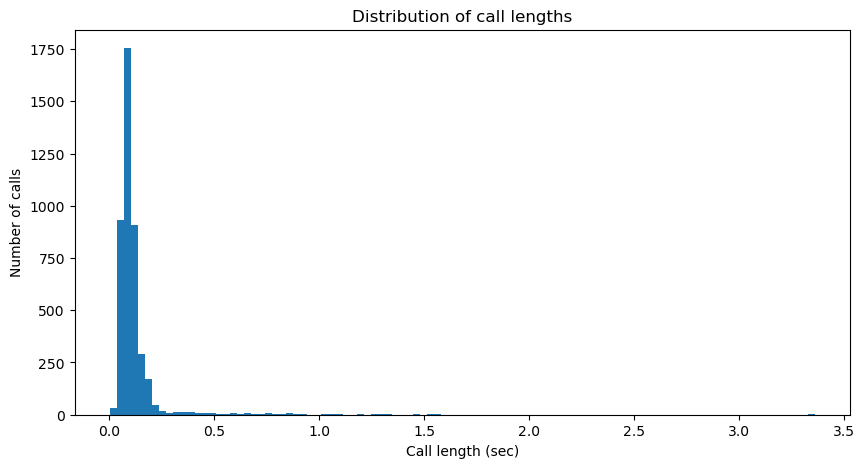

In [11]:
# calculate the length of each call
vocSelTableFull['callLength'] = (vocSelTableFull['StopIndex'] - vocSelTableFull['StartIndex']) / fs
 
# plot the distribution of call lengths
plt.figure(figsize=(10, 5))
plt.hist(vocSelTableFull['callLength'], bins=100)
plt.xlabel('Call length (sec)')
plt.ylabel('Number of calls')
plt.title('Distribution of call lengths')

# The tags have extra characters that I don't want
print(vocSelTableFull['Tags'].unique())
# it appears they have a '[""]' surrounding them
vocSelTableFull['Tags'] = vocSelTableFull['Tags'].str.strip('[""]')
print(vocSelTableFull['Tags'].unique())
# change the tags column of the df to the stripped version
vocSelTableFull['Tags'] = vocSelTableFull['Tags'].str.strip('[""]')

## Now we are going to rearrange the data to do a UMAP projection.
## This requires:
## - taking only some features
## - excluding any rows with NaNs
## - TODO don't lose the NANs so my index isn't wrong
## - zscore and then calculate PCAs
## - we may also may withhold some data to verify our sorting (not now though)

In [12]:
# Generate the data array of biosound features
# X is the data array of features.
startFeat = 3
endFeat = 10
startFeat2 = 11
endFeat2 = 27
# note I added callLength to the features, which is the last one
salInd = 7

XFeatureNames = np.array(np.hstack((vocSelTableFull.columns[startFeat:endFeat],vocSelTableFull.columns[startFeat2:endFeat2],vocSelTableFull.columns[-1:])))
print('Features chosen:', XFeatureNames)
nfeatures = len(XFeatureNames)

Features chosen: ['fund' 'devfund' 'cvfund' 'maxfund' 'minfund' 'F1' 'F2' 'sal' 'rms'
 'maxAmp' 'meanS' 'stdS' 'skewS' 'kurtS' 'entS' 'q1' 'q2' 'q3' 'meanT'
 'stdT' 'skewT' 'kurtT' 'entT' 'callLength']


In [16]:
# Generate the data array of biosound features
# X is the data array of features.
XFeatureNames = np.array(np.hstack([vocSelTableFull.columns[startFeat:endFeat],vocSelTableFull.columns[startFeat2:endFeat2],vocSelTableFull.columns[-1:]]))
print('Features chosen:', XFeatureNames)
nfeatures = len(XFeatureNames)

XBirds = []
indGoodBirds = []
infoBirds = []
nsyllBirds = []
    
X = np.hstack([vocSelTableFull.iloc[:,startFeat:endFeat],vocSelTableFull.iloc[:,startFeat2:endFeat2],vocSelTableFull.iloc[:,-1:]])

# Find the rows that have the full data set
indGood = np.where((np.sum(np.invert(np.isnan(X)), axis=1) == nfeatures) & (X[:,salInd]>0.3))[0]
indBad = np.where((np.sum(np.invert(np.isnan(X)), axis=1) != nfeatures) | (X[:,salInd]<=0.3))[0]
# print(f'badfiles = {indBad}')
indGoodBirds.append(indGood)

# print('nsyll=', len(indGood), '/', X.shape[0])
nsyllBirds.append(len(indGood))
# How many rows are we losing?
print('Number of rows lost:', X.shape[0] - len(indGood))
print('Out of how many rows?', X.shape[0])

# calculate which features are contributing to the missing data
# def print_missing_features(X, XFeatureNames, indBad):
#     missing_features = list()
#     for feature in XFeatureNames:
#         num_missing=0
#         for indBad in indBad: 
#             if np.isnan(X[indBad,np.where(XFeatureNames == feature)[0][0]]):
#                 num_missing += 1
#         if num_missing > 0: print(f'num missing {feature} = {num_missing}')

print_missing_features(X, XFeatureNames, indBad)

cleanX = X[indGood,:]
cleanTags = vocSelTableFull.iloc[indGood,0:3]
print('dimensions of cleanX:', cleanX.shape)
# print cleantages unique
print('unique call types:', np.unique(cleanTags['calltype']))


Features chosen: ['fund' 'devfund' 'cvfund' 'maxfund' 'minfund' 'F1' 'F2' 'sal' 'rms'
 'maxAmp' 'meanS' 'stdS' 'skewS' 'kurtS' 'entS' 'q1' 'q2' 'q3' 'meanT'
 'stdT' 'skewT' 'kurtT' 'entT' 'callLength']
Number of rows lost: 103
Out of how many rows? 4344


TypeError: 'numpy.int64' object is not iterable

In [54]:
files_list[19]

'bird_BluGre1214F_call_[]_971.h5'

In [55]:
# print the names of h5 files with bad indexes
for ind in indBad[0:10]:
    print(f'bad files names = {files_list[ind]}, index = {ind}')

bad files names = bird_WhiWhi6607F_call_["0"]_1134.h5, index = 0
bad files names = bird_BroGre1354M_call_[]_3143.h5, index = 1
bad files names = bird_BluGre1214F_call_[]_2272.h5, index = 22
bad files names = bird_WhiWhi6607F_call_["6"]_2686.h5, index = 23
bad files names = bird_BluGre1214F_call_["6"]_3002.h5, index = 84
bad files names = bird_WhiWhi1541M_call_[]_2921.h5, index = 85
bad files names = bird_WhiWhi1541M_call_["5"]_3605.h5, index = 304
bad files names = bird_BluGre1214F_call_[]_4071.h5, index = 305
bad files names = bird_WhiWhi1541M_call_[]_3286.h5, index = 342
bad files names = bird_WhiWhi1541M_call_[]_227.h5, index = 343


Shape of Z_PCA_All: (4239, 10)


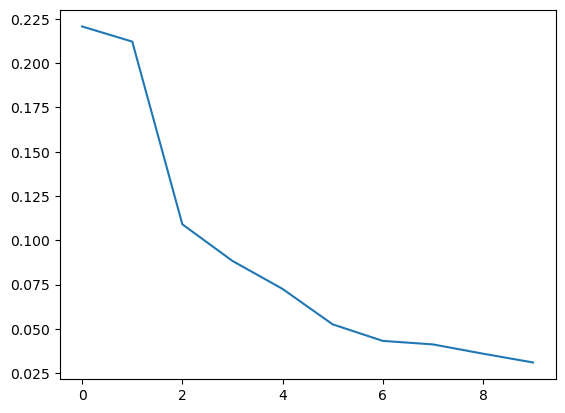

In [16]:
# Zscore the data
meanBalancedAll = np.mean(cleanX, axis = 0)
sdBalancedAll = np.std(cleanX, axis = 0, ddof=1)
ZBalancedAll = (cleanX - meanBalancedAll)/sdBalancedAll

# PCA the data
pcaBalanced = PCA(n_components=10, svd_solver='full')
Z_PCA_Balanced_All = pcaBalanced.fit_transform(ZBalancedAll)

print("Shape of Z_PCA_All:", Z_PCA_Balanced_All.shape)

# Plot the explainable variance
plt.plot(pcaBalanced.explained_variance_ratio_)

(4239, 10)


Text(0.5, 1.0, 'PCA of the data, balanced and zscored, 10 components, 2 dimensions')

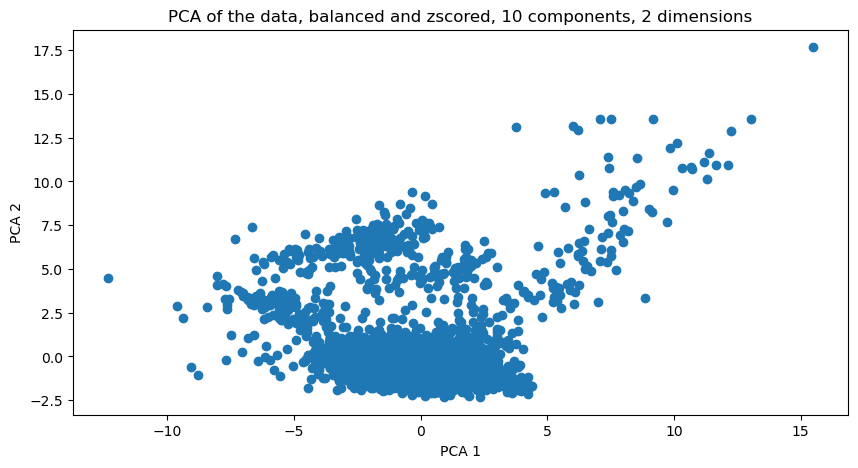

In [17]:
print(Z_PCA_Balanced_All.shape)
# Plot the first two components
plt.figure(figsize=(10, 5))
plt.scatter(Z_PCA_Balanced_All[:,0], Z_PCA_Balanced_All[:,1], cmap = 'tab20')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of the data, balanced and zscored, 10 components, 2 dimensions')


In [18]:
# Take the z-scored PCA data and run UMAP on it

MAXSYLL = 40
umapFit = umap.UMAP(
        n_neighbors=int(len(Z_PCA_Balanced_All)/MAXSYLL),
        min_dist=0.1,
        n_components=3,
        random_state=42).fit(Z_PCA_Balanced_All)

umapAll = umapFit.transform(Z_PCA_Balanced_All)

# umapAllData = umapFit.transform(Z_PCA_Balanced_All)

/opt/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [19]:
# unique tags
print('unique tags:', np.unique(cleanTags['calltype']))


unique tags: ['["distance call?"]' '["wingflap"]' '[]']


Text(0.5, 1.0, 'UMAP colored by soundsep defined call type')

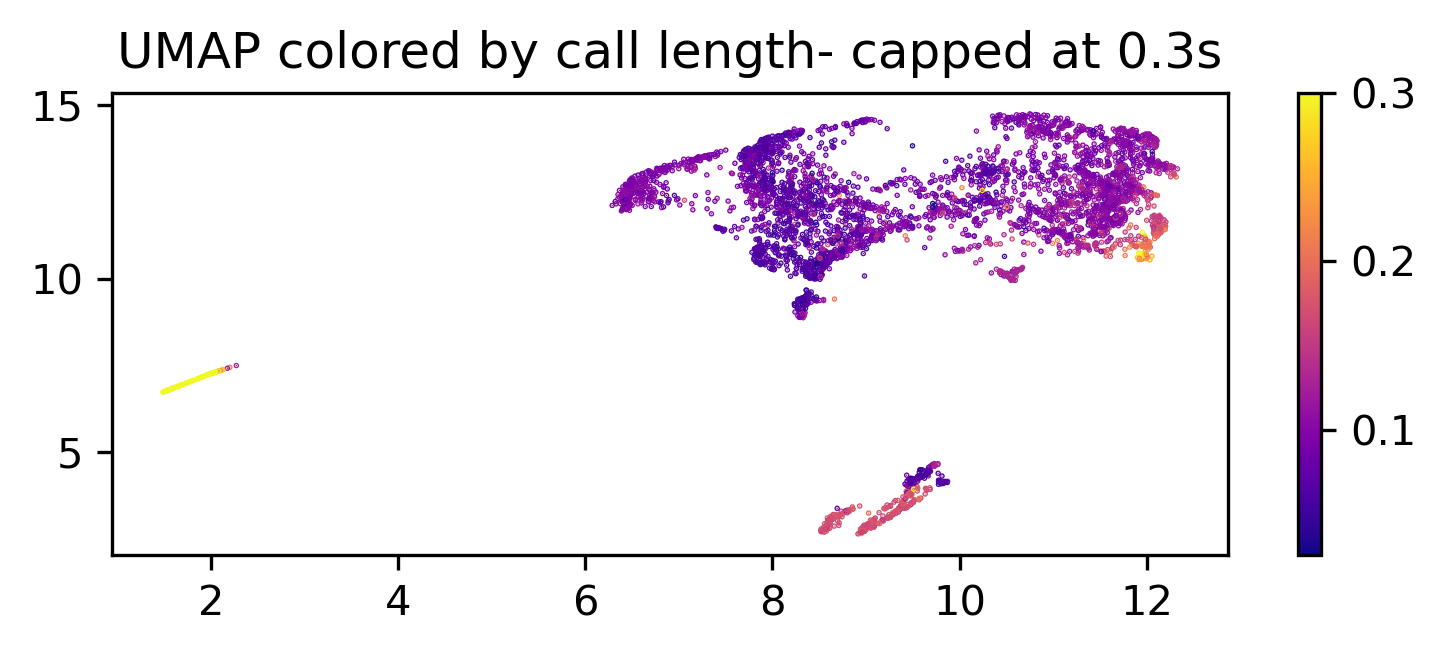

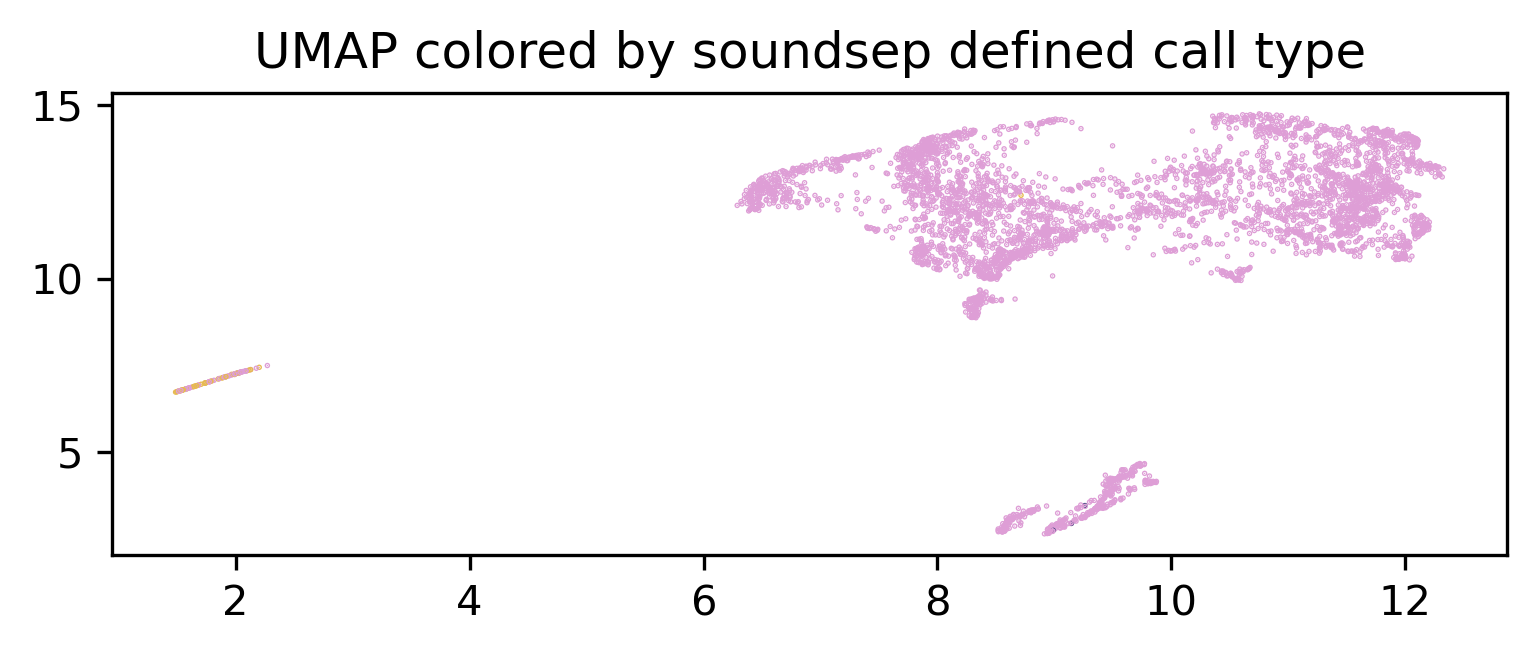

In [20]:
# shift the color index so that 0-.5s contains most of the color range.
# and plot the umap

c=cleanX[:,-1]
c[c>.3]=.3
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapAll[:, 0], umapAll[:, 1], s=0.1, c=c, cmap='plasma')
plt.title('UMAP colored by call length- capped at 0.3s')
plt.colorbar()

# plot the UMAP and color by the original tags of the call type
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapAll[:, 0], umapAll[:, 1], s=0.1, c=cleanTags['calltype'].astype('category').cat.codes, cmap='tab20b')
plt.title('UMAP colored by soundsep defined call type')



In [21]:
# Let's cluster the UMAP data
# HDBSCAN
min_cluster_size = 15
min_samples = 15
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
clusterer.fit(umapAll)


HDBSCAN(min_cluster_size=15, min_samples=15)

## Now let's use some clustering algorithms to assign new tags to our data.
## Afterwards we can re-save the SoundSep tags and look at the syllables there

Counter({1: 3761, 4: 261, 0: 97, 2: 87, 3: 31, -1: 2})


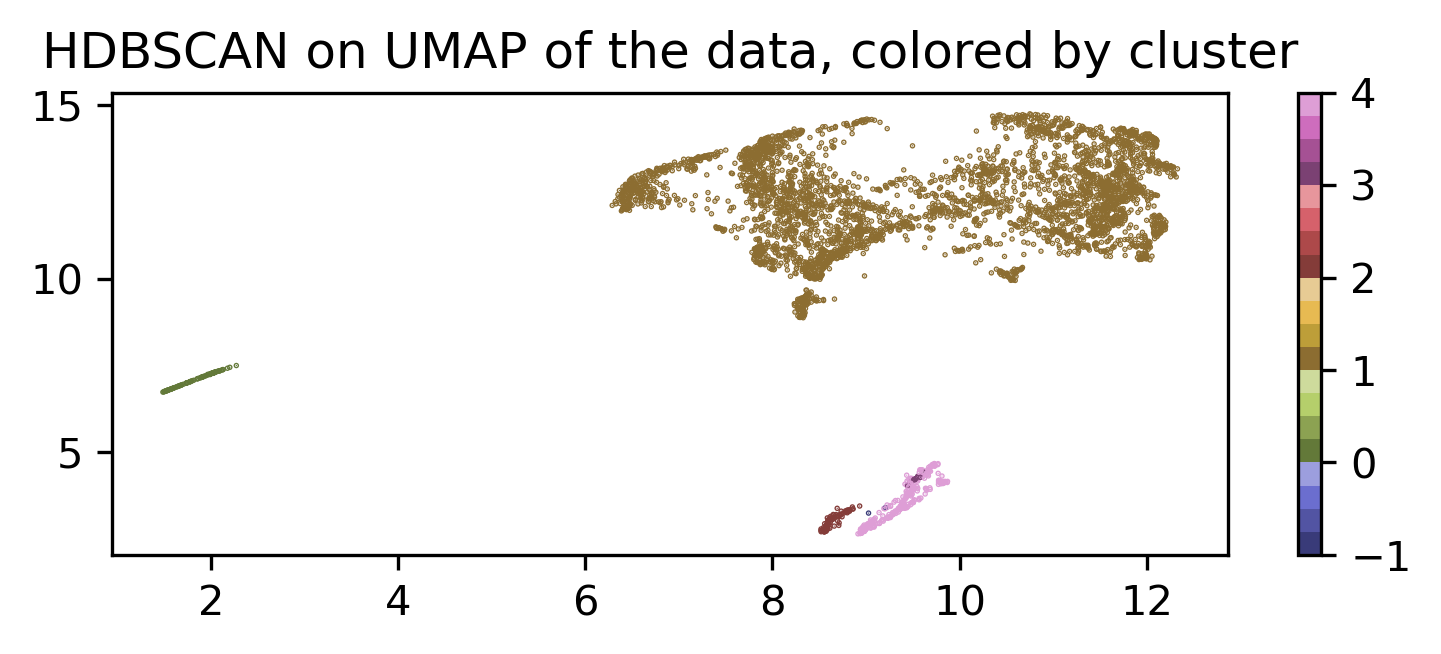

In [22]:
# Plot the clusters
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapAll[:, 0], umapAll[:, 1], s=0.1, c=clusterer.labels_, cmap='tab20b')
plt.title('HDBSCAN on UMAP of the data, colored by cluster')
plt.colorbar()

#print the number data points in each cluster
print(Counter(clusterer.labels_))

## Take just cluster 1 and re-plot it in a new umap space and recluster it and plot those identites


/opt/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


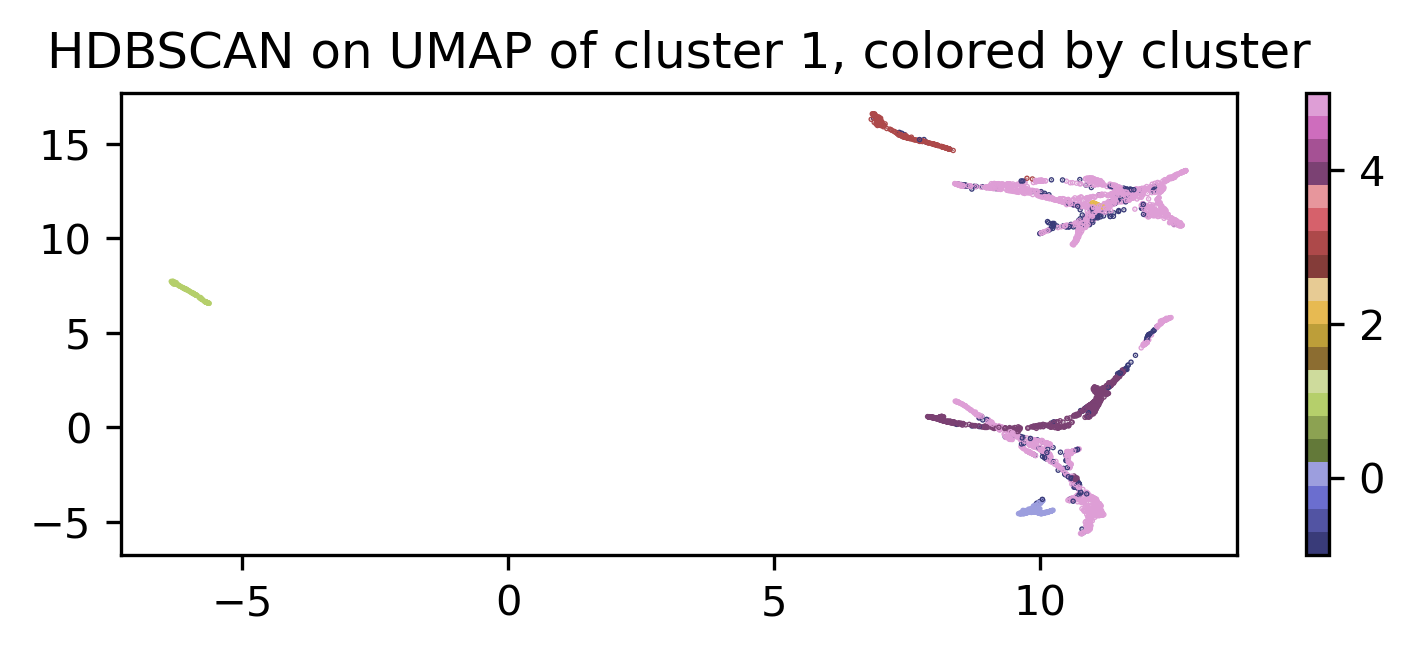

In [23]:
# just take cluster 1 and plot a new umap
indCluster1 = np.where(clusterer.labels_ == 1)[0]
umapCluster1 = umapAll[indCluster1,:]
# plt.figure(figsize=(6,2), dpi=300)
# plt.scatter(umapCluster1[:, 0], umapCluster1[:, 1], s=0.1, c='r')
# plt.title('UMAP of cluster 1')

# but let's try making a new umap fit just based on this cluster
umapFitCluster1 = umap.UMAP(
        n_neighbors=int(len(umapCluster1)/MAXSYLL),
        min_dist=0.1,
        n_components=3,
        random_state=42).fit(umapCluster1)

# project the data into the new umap
umapCluster1Data = umapFitCluster1.transform(umapCluster1)

# now let's cluster the cluster
min_cluster_size = 15
min_samples = 15
cluster_selection_epsilon = 0.4
clustererCluster1 = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=cluster_selection_epsilon)
clustererCluster1.fit(umapCluster1)

# Plot the new umap with new clusters
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapCluster1Data[:, 0], umapCluster1Data[:, 1], s=0.1, c=clustererCluster1.labels_, cmap='tab20b')
plt.title('HDBSCAN on UMAP of cluster 1, colored by cluster')
plt.colorbar()



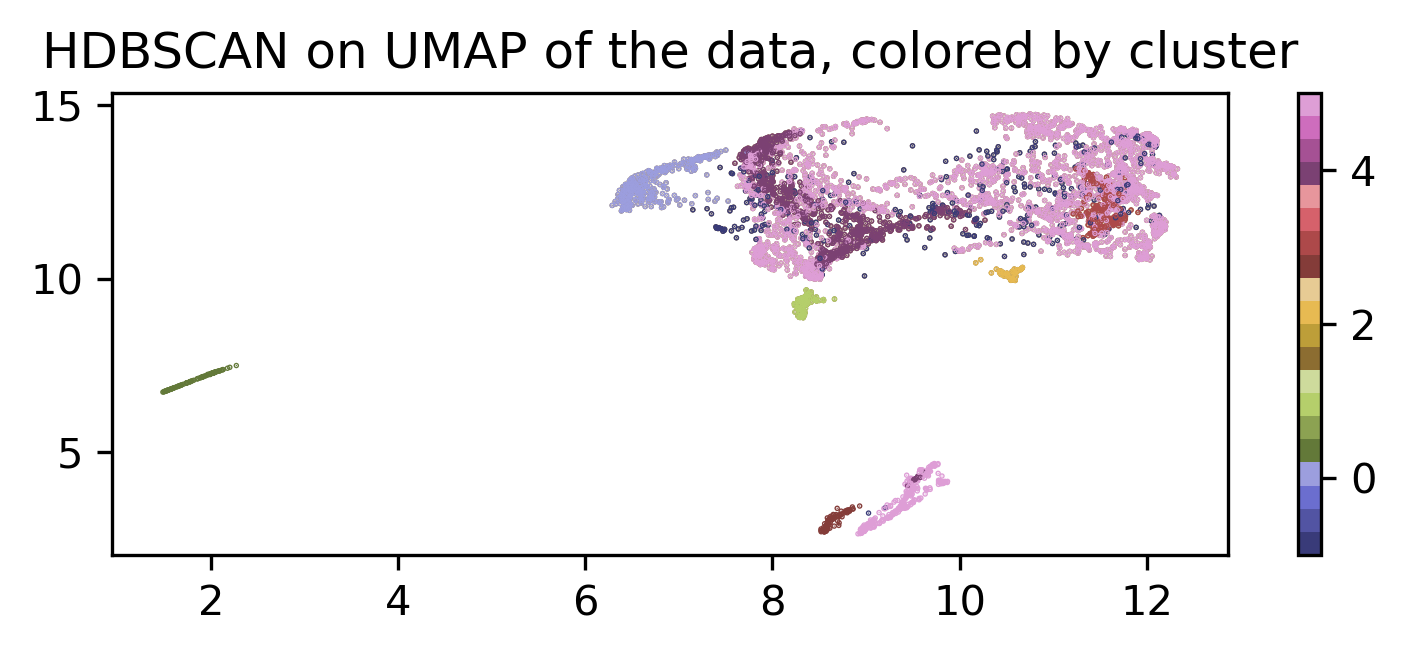

In [24]:
# let's plot the cluster identities in the original umap space
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapAll[:, 0], umapAll[:, 1], s=0.1, c=clusterer.labels_, cmap='tab20b')
plt.scatter(umapCluster1[:, 0], umapCluster1[:, 1], s=0.1, c=clustererCluster1.labels_, cmap='tab20b')
plt.title('HDBSCAN on UMAP of the data, colored by cluster')
plt.colorbar()


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_89734/545747899.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vocSelTableFull['new_clusters'][indGood[clusterer.labels_ != -1]] = clusterer.labels_[clusterer.labels_ != -1] # add the cluster labels to the new column from the first clustering
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_89734/545747899.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vocSelTableFull['new_clusters'][indGood[clusterer.labels_ == 1]] = clustererCluster1.labels_ # add the cluster labels to the new column from the second clustering


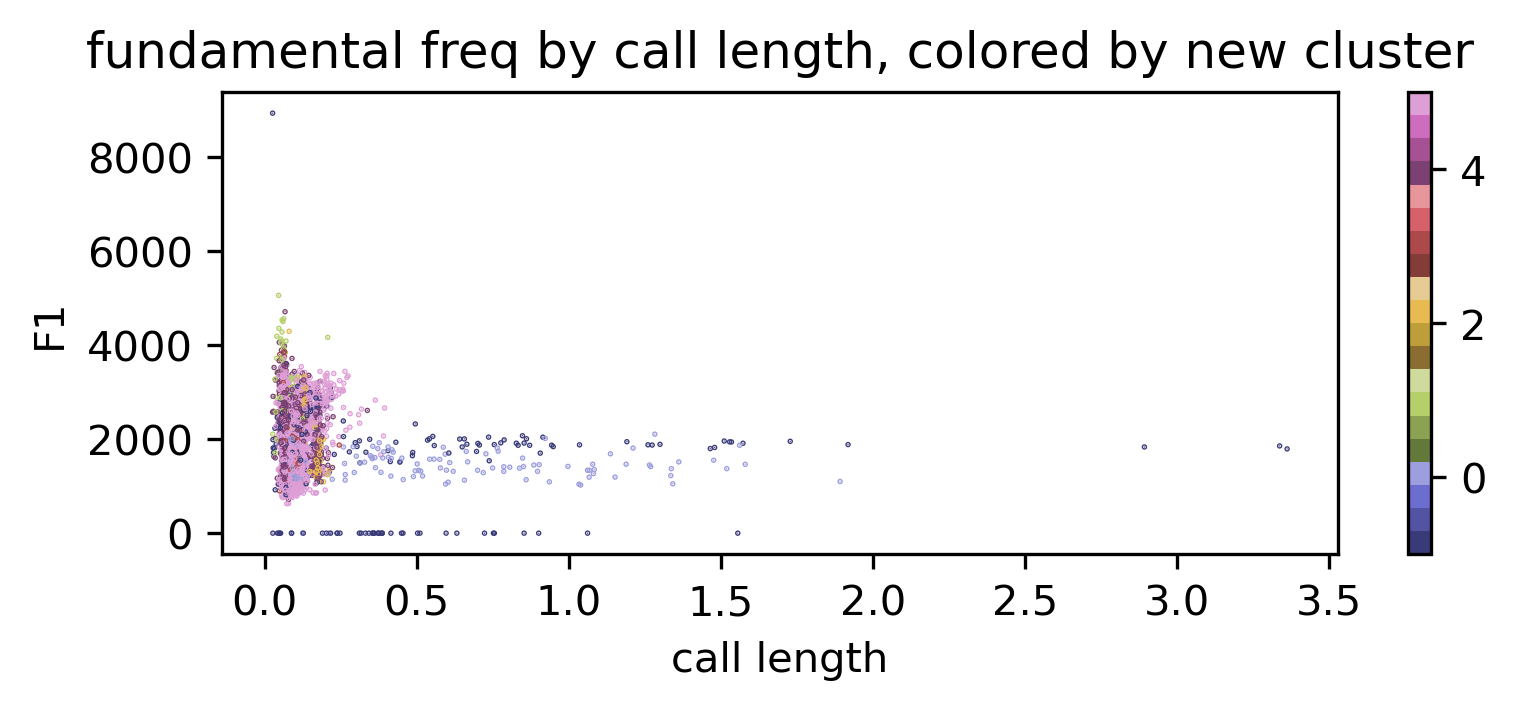

In [25]:
# Ok these clusters look ok let's save them to the original df. 
# First we need to add the cluster labels to the original df
vocSelTableFull['new_clusters'] = -1 # add a new column to the df
vocSelTableFull['new_clusters'][indGood[clusterer.labels_ != -1]] = clusterer.labels_[clusterer.labels_ != -1] # add the cluster labels to the new column from the first clustering
vocSelTableFull['new_clusters'][indGood[clusterer.labels_ == 1]] = clustererCluster1.labels_ # add the cluster labels to the new column from the second clustering

# Let's plot the clusters with the new labels in a simple space to verify the clustering is still correct
plt.figure(figsize=(6,2), dpi=300)
# plt.scatter(vocSelTableFull['Fund'], vocSelTableFull['callLength'], s=0.1, c=vocSelTableFull['new_clusters'], cmap='tab20b')
plt.scatter(vocSelTableFull['callLength'], vocSelTableFull['F1'], s=0.1, c=vocSelTableFull['new_clusters'], cmap='tab20b')
plt.title('fundamental freq by call length, colored by new cluster')
plt.ylabel('F1')
plt.xlabel('call length')
plt.colorbar()



In [26]:
# vocSelTableFull['StartIndex']
# cluster_label = vocSelTableFull['new_clusters'].iloc[i]
# print(cluster_label)
# syllTable['StartIndex'
syllTable

,Unnamed: 0,SourceName,SourceChannel,StartIndex,StopIndex,Tags,Coords
0,0,BroGre1354M,0,705034,709502,"[""1""]","[8.153053283691406, 11.92204475402832, 5.47700..."
1,1,BluGre1214F,2,739121,741816,"[""6""]","[11.00963020324707, 12.903932571411133, 5.4287..."
2,2,BluGre1214F,2,773851,776369,"[""2""]","[11.17556381225586, 11.674291610717773, 3.4400..."
3,3,BluGre1214F,2,844891,848558,"[""6""]","[10.986668586730957, 12.001487731933594, 3.246..."
4,4,BroGre1354M,0,910549,913839,"[""5""]","[9.732298851013184, 11.947017669677734, 0.9106..."
...,...,...,...,...,...,...,...
4339,4339,WhiWhi1541M,3,297302736,297305283,"[""5""]","[2547, 0.28693742156426827]"
4340,4340,BluGre1214F,2,297324812,297329004,"[""6""]","[4192, 0.47131914224117666]"
4341,4341,BluGre1214F,2,297367001,297371644,"[""6""]","[4643, 0.25669652748082805]"
4342,4342,BluGre1214F,2,298070022,298074525,"[""6""]","[4503, 0.7298503326020755]"


In [27]:
# base_folder = '/Users/williamwood/Documents/Data/Field Station Recordings/July_Recordings/14_38_03_18_07_2023'
# syll_file_name = os.path.join(base_folder,'_appdata','save','segments.csv')

In [28]:
# vocSelTableFull['new_clusters'].describe()
# get rid of the negative cluster labels
vocSelTableFull['new_clusters'] = vocSelTableFull['new_clusters'] + 1
vocSelTableFull['new_clusters'].describe()

count    4335.000000
mean        4.438062
std         2.112935
min         0.000000
25%         4.000000
50%         5.000000
75%         6.000000
max         6.000000
Name: new_clusters, dtype: float64

In [29]:
# yeah that looks fine. 
# to resave the segments.csv file with the new cluster labels we need to put the new cluster labels back into the segments.csv file
# first we need to get the start and stop indices of the calls that we have in the vocSelTableFull
# we can then use these to replace the cluster labels in the segments.csv file
# we can then save the segments.csv file back to the original location

import json
for i in range(len(vocSelTableFull)):
    start_index = vocSelTableFull['StartIndex'].iloc[i]
    stop_index = vocSelTableFull['StopIndex'].iloc[i]
    cluster_label = vocSelTableFull['new_clusters'].iloc[i]
    syllTable.loc[syllTable['StartIndex'] == start_index, 'Tags'] = json.dumps(list(str(cluster_label)))

print(len(syllTable))
syllTable.to_csv(syll_file_name, index=False)

# vocSelTableFull.to_hdf(os.path.join(base_folder, 'vocSelTableAmp.h5'), 'callTable', mode = 'w')
# print('File saved to', os.path.join(base_folder, 'vocSelTableAmp.h5'))

4344


In [30]:
# you have to copy and paste these into the tags.csv file
# The unique tags
tags = np.unique(syllTable['Tags'])

# Copy and paste this output to tags.csv
print(',TagName')
i=0
for itag, tag in enumerate(tags):
    print('{},{}'.format(itag, tag[2:-2]))
    # print(tag)
    i+=1

# # Write Labelled file to disk
# syllTable.to_csv(syllableOut)
# print(len(syllTable))
# print(len(vocSelTableFull))

,TagName
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,


# TODO I need to check that I'm not losing segments because it looks like it in soundsep

In [31]:
# # Write tagged segment file

# segmentTable = syllTable[["source.name", "source.channel", 
#                           "project.start_index", "project.stop_index", "tags"]].copy()
# segmentTable.rename(columns = {'source.name':'SourceName', 'source.channel':'SourceChannel', 
#                                'project.start_index':'StartIndex', 'project.stop_index':'StopIndex',
#                                'tags':'Tags' }, inplace = True)
# segmentOut = f'/Users/frederictheunissen/Work Data/Canary/Group{groupID}/Group{groupID}Output/segments.csv'

# segmentTable.to_csv(segmentOut)

# Write tagged segment file


In [32]:
# The unique tags
tags = np.unique(segmentTable['Tags'])

# Copy and paste this output to tags.csv
print(',TagName')
for itag, tag in enumerate(tags):
    print('{},{}'.format(itag, tag[2:-2]))
    

NameError: name 'segmentTable' is not defined

In [34]:
print(f' len(seg_df) is : {len(seg_df)} and len(umapAll) is : {len(umapAll)}')
len(umapAll)
umapAll.dtype

 len(seg_df) is : 4344 and len(umapAll) is : 4239


dtype('float32')

In [ ]:
new_coords = umapAll.astype(float)
a = [list(x) for x in new_coords]

In [ ]:
seg_df.head()

,Unnamed: 0.1,Unnamed: 0,SourceName,SourceChannel,StartIndex,StopIndex,Tags,cluster
0,0,0,BroGre1354M,0,705034,709502,"[""1""]",0.0
1,1,1,BluGre1214F,2,739121,741816,"[""6""]",5.0
2,2,2,BluGre1214F,2,773851,776369,"[""2""]",1.0
3,3,3,BluGre1214F,2,844891,848558,"[""6""]",5.0
4,4,4,BroGre1354M,0,910549,913839,"[""5""]",4.0


In [33]:
project_dir = '/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023'
seg_df = pd.read_csv(os.path.join(project_dir,'_appdata/save/segments.csv'))
new_coords = umapAll.astype(float)    # n x 3 array
seg_df['Coords'] = None
seg_df.loc[indGood,'Coords'] = [json.dumps(list(x)) for x in new_coords]
seg_df.to_csv(os.path.join(project_dir,'_appdata/save/segments.csv'))